<center><img src="https://raw.githubusercontent.com/openvinotoolkit/anomalib/development/docs/source/images/logos/anomalib-wide-blue.png" alt="Paris" class="center"></center>

<center>💙 A library for benchmarking, developing and deploying deep learning anomaly detection algorithms</center>

---

> NOTE: 
This notebook is originally created by @innat on [Kaggle](https://www.kaggle.com/code/ipythonx/mvtec-ad-anomaly-detection-with-anomalib-library/notebook). 

[Anomalib](https://github.com/openvinotoolkit/anomalib): Anomalib is a deep learning library that aims to collect state-of-the-art anomaly detection algorithms for benchmarking on both public and private datasets. Anomalib provides several ready-to-use implementations of anomaly detection algorithms described in the recent literature, as well as a set of tools that facilitate the development and implementation of custom models. The library has a strong focus on image-based anomaly detection, where the goal of the algorithm is to identify anomalous images, or anomalous pixel regions within images in a dataset.

The library supports [`MVTec AD`](https://www.mvtec.com/company/research/datasets/mvtec-ad) (CC BY-NC-SA 4.0) and [`BeanTech`](https://paperswithcode.com/dataset/btad) (CC-BY-SA) for **benchmarking** and `folder` for custom dataset **training/inference**. In this notebook, we will explore `anomalib` training a PADIM model on the `MVTec AD` bottle dataset and evaluating the model's performance. The sections in this notebook explores the steps in `tools/train.py` more in detail. Those who would like to reproduce the results via CLI could use `python tools/train.py --model padim`. 

## Installing Anomalib
Installation can be done in two ways: (i) install via PyPI, or (ii) installing from source. In this notebook, we'll install it from the PyPI version for the sake of simplicity.

## Imports

In [1]:
import logging
import warnings
from pathlib import Path

import numpy as np

def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings('ignore')
logger = logging.getLogger("anomalib")
from typing import Any, Dict

import numpy as np
from PIL import Image
from pytorch_lightning import Trainer
from torchvision.transforms import ToPILImage

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from anomalib.utils.loggers import get_experiment_logger


## Model

Currently, there are **7** anomaly detection models available in `anomalib` library. Namely, 

- [CFlow](https://arxiv.org/pdf/2107.12571v1.pdf)
- [DFKDE](https://github.com/openvinotoolkit/anomalib/tree/development/anomalib/models/dfkde)
- [DFM](https://arxiv.org/pdf/1909.11786.pdf)
- [Ganomaly](https://arxiv.org/abs/1805.06725)
- [Padim](https://arxiv.org/pdf/2011.08785.pdf)
- [Patchcore](https://arxiv.org/pdf/2106.08265.pdf)
- [STFPM](https://arxiv.org/pdf/2103.04257.pdf)

In this tutorial, we'll be using Padim. Now, let's get their config paths from the respected folders.

## Configuration

In this demonstration, we will choose [Padim](https://arxiv.org/pdf/2011.08785.pdf) model from the above config; which is index 1 in the above dictionary. Let's take a quick look of its config file. 

In [3]:
MODEL = 'padim' # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
CONFIG_PATH = f"../../anomalib/models/{MODEL}/cubes_config.yaml"
print(open(CONFIG_PATH, 'r').read())

dataset:
  name: cubes #options: [mvtec, btech, folder]
  format: folder
  path: C:/Intel/datasets/datasets/cubes/training
  normal_dir: normal # name of the folder containing normal images.
  abnormal_dir: anormal # name of the folder containing abnormal images
  task: classification
  mask: null
  normal_test_dir: null # optional
  extensions: null
  split_ratio: 0.2  # normal images ratio to create a test split
  seed: 0
  image_size: 256
  train_batch_size: 32
  test_batch_size: 32
  num_workers: 8
  transform_config:
      train: null
      val: null
  create_validation_set: true
  tiling:
    apply: false
    tile_size: null
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_tile_count: 16

model:
  name: padim
  backbone: resnet18
  pre_trained: true
  layers:
    - layer1
    - layer2
    - layer3
  normalization_method: min_max # options: [none, min_max, cdf]

metrics:
  image:
    - F1Score
    - AUROC
  pixel:
    - F1Score
    - AUROC
  thre

We could use [get_configurable_parameter](https://github.com/openvinotoolkit/anomalib/blob/development/anomalib/config/config.py#L114) function to read the configs from the path and return them in a dictionary. We use the default config file that comes with Padim implementation, which uses `./datasets/MVTec` as the path to the dataset. We need to overwrite this after loading the config.

In [4]:
# pass the config file to model, logger, callbacks and datamodule
config = get_configurable_parameters(config_path=CONFIG_PATH)
config["dataset"]["path"] = "C:/Intel/datasets/datasets/cubes/training"     # or wherever the Custom Dataset is stored.
print(config)

{'dataset': {'name': 'cubes', 'format': 'folder', 'path': 'C:/Intel/datasets/datasets/cubes/training', 'normal_dir': 'normal', 'abnormal_dir': 'anormal', 'task': 'classification', 'mask': None, 'normal_test_dir': None, 'extensions': None, 'split_ratio': 0.2, 'seed': 0, 'image_size': [256, 256], 'train_batch_size': 32, 'test_batch_size': 32, 'num_workers': 8, 'transform_config': {'train': None, 'val': None}, 'create_validation_set': True, 'tiling': {'apply': False, 'tile_size': None, 'stride': None, 'remove_border_count': 0, 'use_random_tiling': False, 'random_tile_count': 16}}, 'model': {'name': 'padim', 'backbone': 'resnet18', 'pre_trained': True, 'layers': ['layer1', 'layer2', 'layer3'], 'normalization_method': 'min_max', 'input_size': [256, 256]}, 'metrics': {'image': ['F1Score', 'AUROC'], 'pixel': ['F1Score', 'AUROC'], 'threshold': {'method': 'adaptive', 'manual_image': None, 'manual_pixel': None}}, 'visualization': {'show_images': False, 'save_images': True, 'log_images': True, 'i

## Dataset: Cubes

Prepare your own dataset for normal and defect pieces.

In [5]:
datamodule = get_datamodule(config)
datamodule.setup()          # Downloads the dataset if it's not in the specified `root` directory
datamodule.prepare_data()   # Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))
data.keys()

Transform configs has not been provided. Images will be normalized using ImageNet statistics.
Transform configs has not been provided. Images will be normalized using ImageNet statistics.


dict_keys(['image', 'image_path', 'label'])

Let's check the shapes of the input images and masks.

In [6]:
data["image"].shape  #   data["mask"].shape

torch.Size([9, 3, 256, 256])

We could now visualize a normal and abnormal sample from the validation set.

## Prepare Model and Callbacks
Now, the config file is updated as we want. We can now start model training with it.

In [7]:
model = get_model(config)
callbacks = get_callbacks(config)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\pjram/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth


In [9]:
# start training
trainer = Trainer(**config.trainer, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
Missing logger folder: results\padim\cubes\lightning_logs
Cannot perform pixel-level evaluation when task type is classification. Ignoring the following pixel-level metrics: ['F1Score', 'AUROC']

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AnomalyScoreThreshold    | 0   

Epoch 0:  50%|████████████████████████████                            | 1/2 [00:06<00:06,  6.31s/it, loss=nan, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████| 2/2 [00:15<00:00,  7.55s/it, loss=nan, v_num=0, image_F1Score=1.000, image_AUROC=1.000]


## Validation

In [10]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)
trainer.test(model=model, datamodule=datamodule)

Cannot perform pixel-level evaluation when task type is classification. Ignoring the following pixel-level metrics: ['F1Score', 'AUROC']


Testing DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC                  1.0
      image_F1Score         0.9333333373069763
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'image_F1Score': 0.9333333373069763, 'image_AUROC': 1.0}]

By default, the output images are saved into `results` directory. We could get the output filenames from the directory, read the saved the images and visualize here. 

In [11]:
config["project"]["path"]

'results\\padim\\cubes'

In [12]:
image_filenames = [filename for filename in Path(config["project"]["path"]).glob("**/*.jpg")]
image_filenames[0]

WindowsPath('results/padim/cubes/images/anormal/input_20220719125602.jpg')

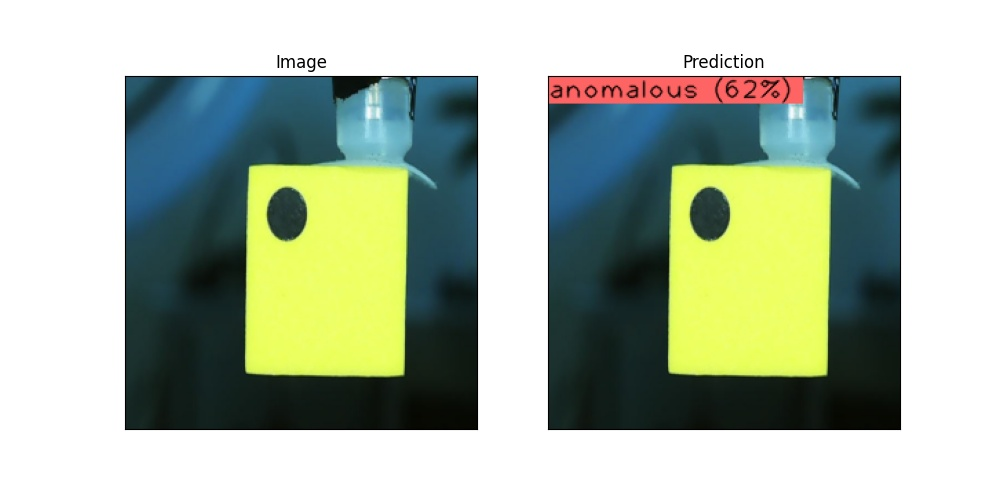

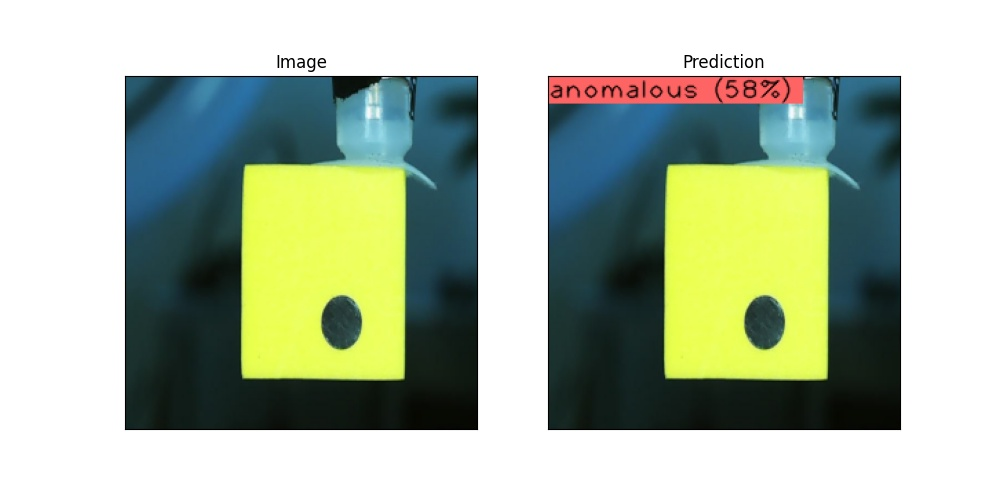

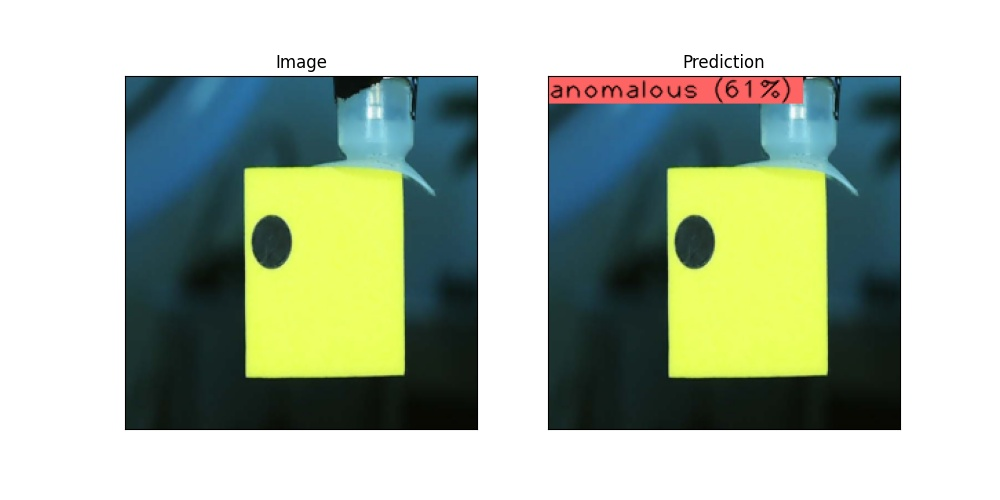

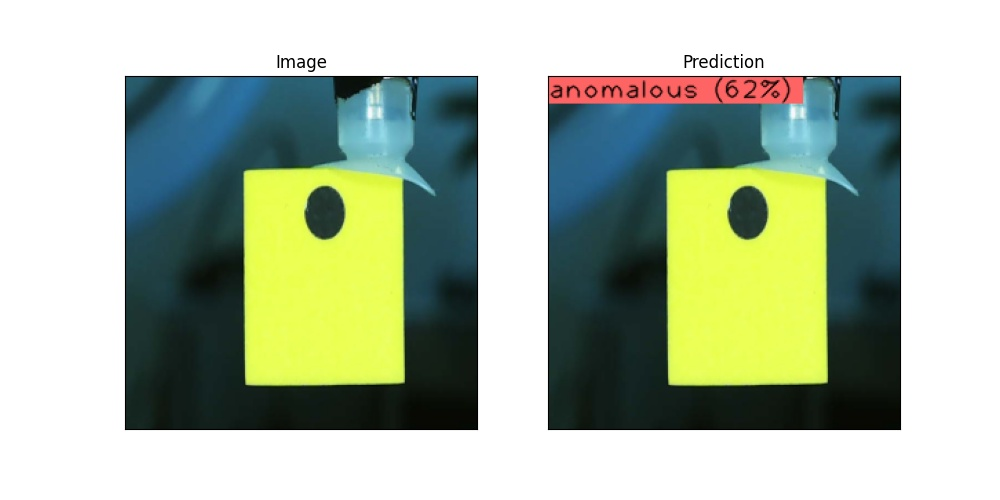

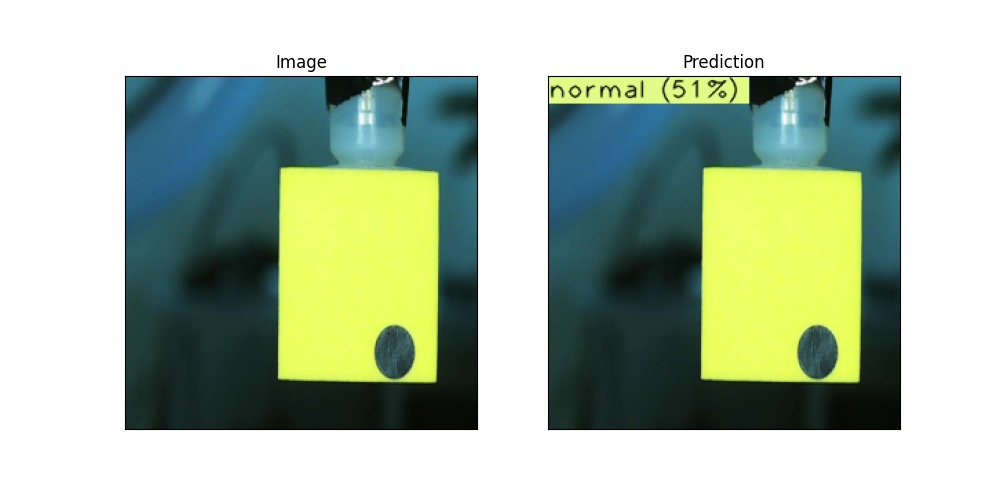

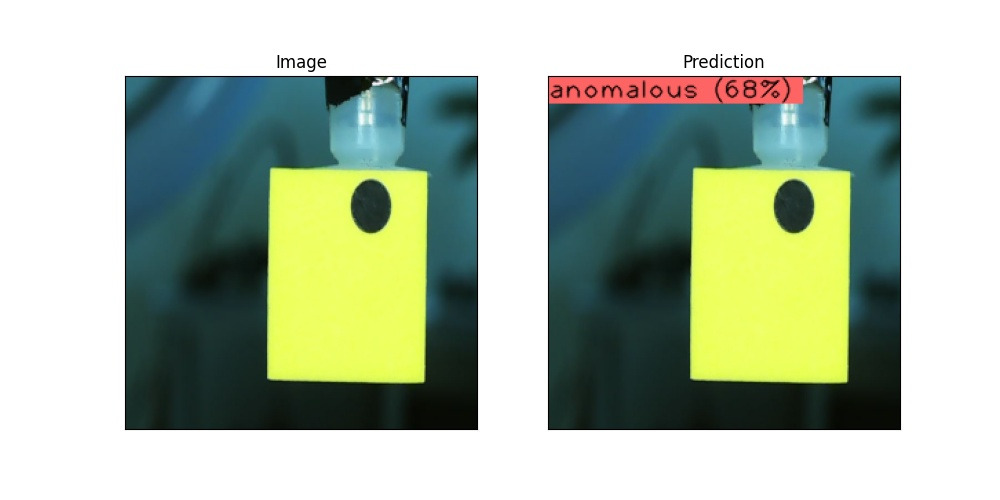

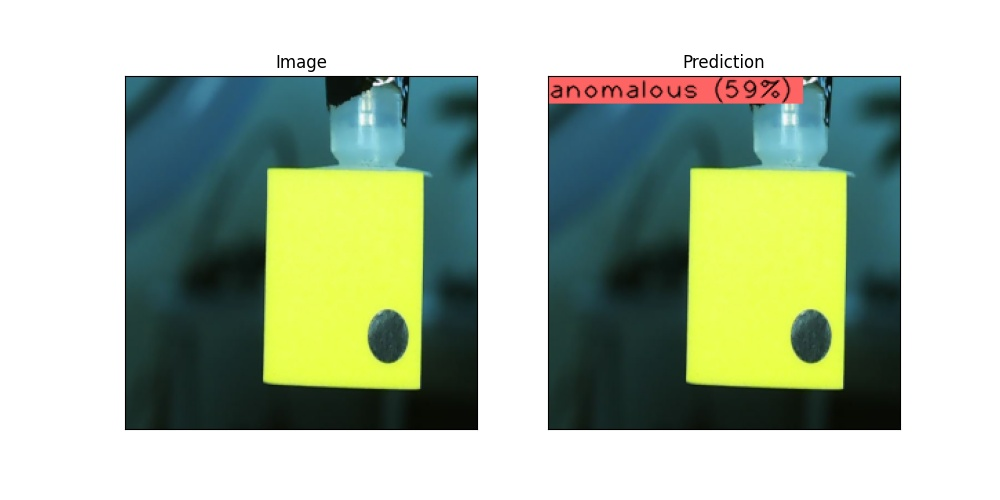

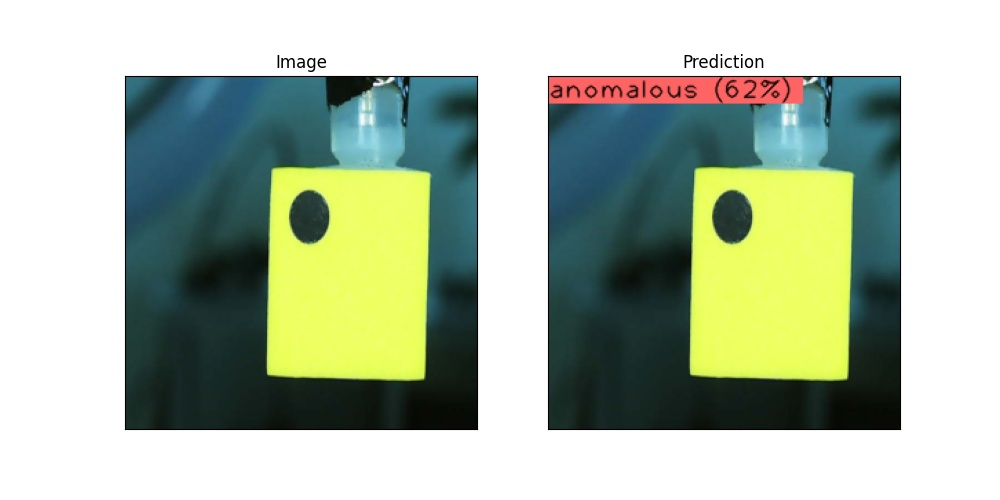

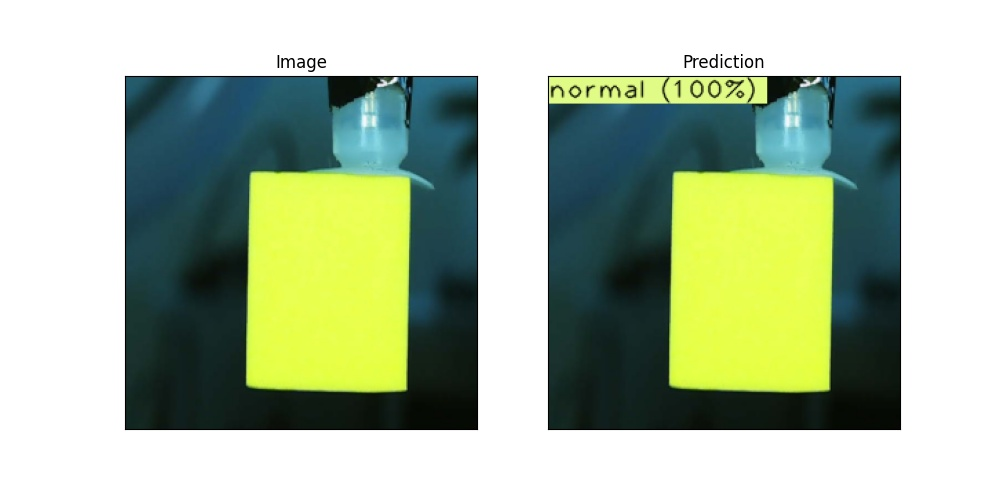

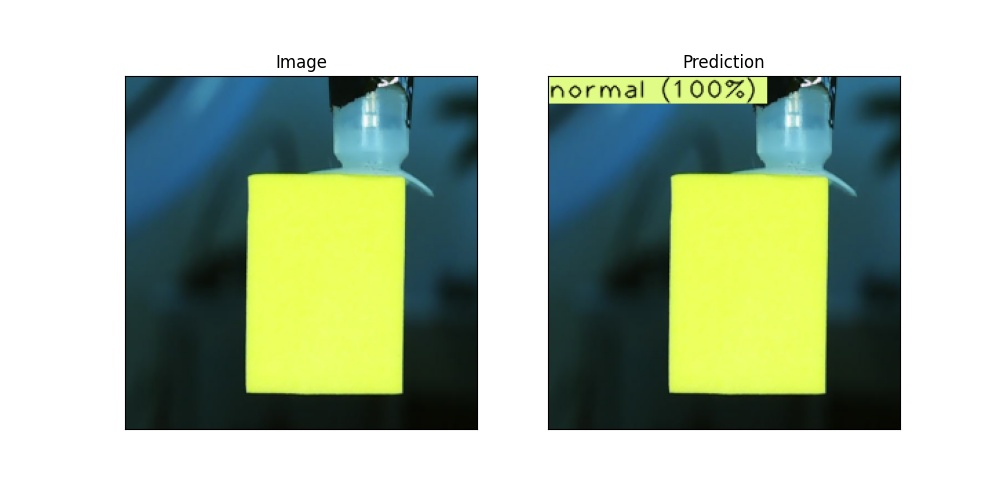

In [13]:
for filename in image_filenames:
    image = Image.open(filename)
    display(image)